# 1. Training Networks

In this section we will build two Neural Networks, one from scratch, and one based on the high-level functions provided by Tensorflow.

We will build a net from scratch to solve the XOR problem, and to do this we will rely on the backpropagation formulae that you have derived in the problem sheet.

We will also build a network with Tensorflow to introduce you to their API.

## 1.1 XOR problem - NN from Scratch

In this problem we have four possible inputs with two possible outcomes; 

 
> $x_1 = 0, x_2 = 0 \Rightarrow XOR(x_1,x_2)=0$

> $x_1 = 0, x_2 = 1 \Rightarrow XOR(x_1,x_2)=1$

> $x_1 = 1, x_2 = 0 \Rightarrow XOR(x_1,x_2)=1$

> $x_1 = 1, x_2 = 1 \Rightarrow XOR(x_1,x_2)=0$

In the problem sheet you may have noticed that a two layer NN  could solve this problem exactly. Here we will see that on a 2-layer net with Sigmoid activation functions, with a random intialisation and the mean square loss, back-prop is able to converge to a pseudo-optimal solution. We will then consider a visualisation of how the neural network divides the input space as a classifier.



**Exercise** The class for the NeuralNet is already defined except for the backpropagation function, which you have to complete.

Note: Once you have implemented backprop, if you get poor performance, try running the cell again.

In [76]:
import numpy as np

def sigmoid(x):
    return 1.0/(1+ np.exp(-x))
    
def sigmoid_derivative(x):
    return sigmoid(x) * (1.0 - sigmoid(x)) # ???????????????????????????????????????????????????????????
                                           # Who put x * (1 - x) as the sigmoid derivative ?????????? 
                                           # This took me a whole day to look into!!! merde



class NeuralNetwork:
    def __init__(self, x, y):
        dimension = 2
        self.input        = x
        self.weights1     = np.random.rand(dimension, x.shape[1])      #np.array([[-1,1],[1,-1]], dtype=np.float) #
        self.weights2     = np.random.rand(1,dimension)      
        self.bias1        = np.random.rand(dimension,1)      #0.5*np.ones((dimension,1)) # np.random.rand(dimension,1)      #
        self.bias2        = np.random.rand(1,1)           
        self.y            = y
        self.output       = np.zeros(self.y.shape)
        self.activation   = sigmoid
        self.d_activation = sigmoid_derivative

    def feedforward(self,x):
        self.x = np.expand_dims(x,axis =1)
        
        self.z1 = self.weights1 @  self.x + self.bias1
        self.layer1 = self.activation(self.z1)
                
        self.z2 = self.weights2 @ self.layer1 + self.bias2
        self.output = self.activation(self.z2)

    def call(self,x):
        x = np.expand_dims(x,axis =1)
        layer1 = self.activation(self.weights1 @  x + self.bias1)
        output = self.activation(self.weights2 @ layer1 + self.bias2)
        return output

    def backprop(self):
        # application of the chain rule to find derivative of the loss function with respect to weights2 and weights1
        d_weights1 = np.zeros(self.weights1.shape)
        d_weights2 = np.zeros(self.weights2.shape)
        d_bias1    = np.zeros(self.bias1.shape)
        d_bias2    = np.zeros(self.bias2.shape)
        lr = 1
        for j in range(4):
          # compute gradient per each input image
          single_input = self.input[j]
          # single_y = np.expand_dims(self.y[j], axis = 1)
          self.feedforward(single_input)
          d_loss = (self.output - self.y[j])/4

          self.delta2 = d_loss @ sigmoid_derivative(self.z2)
          d_bias2    += self.delta2

          d_weights2 += self.delta2 @ self.layer1.T
          
          self.delta1 = (self.weights2.T @(self.delta2)) * sigmoid_derivative(self.z1)
          d_weights1 += self.delta1.dot(self.x.T) # self.delta2.dot(self.layer1.T)
          d_bias1    += self.delta1

        self.weights1 -= d_weights1 * lr
        self.weights2 -= d_weights2 * lr
        self.bias1    -= d_bias1 * lr
        self.bias2    -= d_bias2 * lr

X = np.array([[0,0],
              [0,1],
              [1,0],
              [1,1]])
y = np.array([[0],[1],[1],[0]])

nn = NeuralNetwork(X,y)

for i in range(10000):
    nn.backprop()
for j in range(4):
    nn.feedforward(X[j])
    print('Prediction:\n', nn.x, ' --->' , nn.output)


Prediction:
 [[0]
 [0]]  ---> [[0.03234871]]
Prediction:
 [[0]
 [1]]  ---> [[0.97146047]]
Prediction:
 [[1]
 [0]]  ---> [[0.97145189]]
Prediction:
 [[1]
 [1]]  ---> [[0.03004223]]


Now we will plot how the domain has been split. In the left figure we will see the outputs of the NN, while on the right we visualise the classification of these outputs i.e. any value above 0.5 identifies class 1, 0 otherwise, which shows us the decision boundary of the classifier.


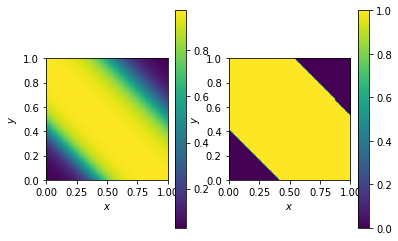

In [77]:
import matplotlib.pyplot as plt
import numpy as np 

mu = np.linspace(0,1,100)
gamma = np.linspace(0,1,100)

# filling the heatmap, value by value
fun_map = np.empty((mu.size, gamma.size))
for i in range(mu.size):
    for j in range(gamma.size):
        net_val = nn.call([mu[i], gamma[j]])
        if net_val>0.5:
          fun_map[i,j] = 1
        else:
          fun_map[i,j] = 0

fun_map_2 = np.empty((mu.size, gamma.size))
for i in range(mu.size):
    for j in range(gamma.size):
        fun_map_2[i,j] = nn.call([mu[i], gamma[j]])

fig = plt.figure()
s = fig.add_subplot(1, 2, 1, xlabel='$x$', ylabel='$y$')
im = s.imshow(
    fun_map_2,
    extent=(gamma[0], gamma[-1], mu[0], mu[-1]),
    origin='lower')
fig.colorbar(im)
s = fig.add_subplot(1, 2, 2, xlabel='$x$', ylabel='$y$')
im = s.imshow(
    fun_map,
    extent=(gamma[0], gamma[-1], mu[0], mu[-1]),
    origin='lower')
fig.colorbar(im)


N.B. The transition fase with the sigmoid activation function is sharp, and so the NN more-or-less splits the domain into piecwise constant regions.

## 1.2 Training MNIST

First, we have to upload the dataset; keras, an interface for tensorflow, allows us to do this with a one line command. We then can use the Sequence model class from TF to add different layers to our network.



In [78]:
from keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels)= mnist.load_data()

print(train_images.shape) # Check if images are loaded correctly



(60000, 28, 28)


x_train[0]

**Exercise** You now have to generate a two layer network with hidden dimension of 128 via the sequential command in Tensorflow. This should allow you to achieve 92% accuracy with only15 epochs of training!!

In [10]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.optimizers import RMSprop

# Generate data
x_train = train_images
y_train = train_labels

x_test = test_images
y_test = test_labels

# build the architecture with Sequential
# ...
model = Sequential([Flatten(input_shape = (28, 28)),
                    Dense(128, activation='relu'),
                    # Dense(64, activation='relu'),
                    # Dense(64, activation='relu'),
                    Dense(10, activation='softmax'),])

# Compile the model, which involved shoows a loss function, an optimiser, and the performance metrics you want to track
# ...
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics = ['accuracy'])

In [11]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


In [12]:
# train the architecture
#...
model.fit(x_train, y_train, epochs = 15)

Epoch 1/15
1875/1875 [==============================] - 2s 896us/step - loss: 2.4151 - accuracy: 0.8579
Epoch 2/15
1875/1875 [==============================] - 2s 876us/step - loss: 0.3719 - accuracy: 0.9111
Epoch 3/15
1875/1875 [==============================] - 2s 851us/step - loss: 0.2801 - accuracy: 0.9303
Epoch 4/15
1875/1875 [==============================] - 2s 923us/step - loss: 0.2365 - accuracy: 0.9395
Epoch 5/15
1875/1875 [==============================] - 1s 782us/step - loss: 0.2138 - accuracy: 0.9469
Epoch 6/15
1875/1875 [==============================] - 1s 726us/step - loss: 0.2066 - accuracy: 0.9492
Epoch 7/15
1875/1875 [==============================] - 1s 745us/step - loss: 0.1980 - accuracy: 0.9510
Epoch 8/15
1875/1875 [==============================] - 2s 828us/step - loss: 0.1875 - accuracy: 0.9539
Epoch 9/15
1875/1875 [==============================] - 1s 751us/step - loss: 0.1778 - accuracy: 0.9565
Epoch 10/15
1875/1875 [==============================] - 1s 715u

In [13]:
# test the performance
# ...
model.evaluate(x_test, y_test)

313/313 [==============================] - 0s 480us/step - loss: 0.4381 - accuracy: 0.9427


[0.43811288475990295, 0.9427000284194946]

# 2. Expressivity

The **$n$-ap problem** was shown to have an optimal solution with a particular construction of neural network. Do we find these coefficients/weights when training a network with that structure from randomly inittialised weights?

**Exercise** Build the net in the case with $n=2^K, K=3$ and check if it converges.

In [230]:
# import tensorflow as tf
# def my_leaky_relu(x):
#     return tf.nn.leaky_relu(x, alpha=0.01)

In [275]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.optimizers import Adam, RMSprop

# Generate data
X = np.array([[0],
                  [.125],
                  [.25],
                  [.375],
                  [.5],
                  [.625],
                  [.75],
                  [.875]])
y = np.array([[0],
              [1],[0],[1],[0],[1],[0],
              [1]])
x_train = X
y_train = y

# Build a model
# ...
model = Sequential([Dense(100, activation = 'relu'),
                    Dense(100, activation = 'relu'),
                    Dense(100, activation = 'relu'),
                    Dense(100, activation = 'relu'),

                    Dense(1, activation = 'relu')])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
# ...
model.fit(x_train, y_train, epochs = 2000)

scores = model.evaluate(X, y)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

ynew = model.predict_classes(x_train)
for i in range(len(x_train)):
	print("Y=%s, Predicted=%s" % (y_train[i], ynew[i]))

Epoch 1/2000
1/1 [==============================] - 0s 1ms/step - loss: 2.0089 - accuracy: 0.5000
Epoch 2/2000
1/1 [==============================] - 0s 899us/step - loss: 1.3779 - accuracy: 0.5000
Epoch 3/2000
1/1 [==============================] - 0s 929us/step - loss: 1.1938 - accuracy: 0.5000
Epoch 4/2000
1/1 [==============================] - 0s 758us/step - loss: 1.0849 - accuracy: 0.5000
Epoch 5/2000
1/1 [==============================] - 0s 2ms/step - loss: 1.0029 - accuracy: 0.5000
Epoch 6/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.9375 - accuracy: 0.5000
Epoch 7/2000
1/1 [==============================] - 0s 912us/step - loss: 0.8841 - accuracy: 0.5000
Epoch 8/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.8395 - accuracy: 0.5000
Epoch 9/2000
1/1 [==============================] - 0s 752us/step - loss: 0.8026 - accuracy: 0.5000
Epoch 10/2000
1/1 [==============================] - 0s 717us/step - loss: 0.7712 - accuracy: 0.6250
Epoch 1

1/1 [==============================] - 0s 773us/step - loss: 0.5798 - accuracy: 0.6250
Epoch 165/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.5796 - accuracy: 0.6250
Epoch 166/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.5797 - accuracy: 0.6250
Epoch 167/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.5794 - accuracy: 0.6250
Epoch 168/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.5793 - accuracy: 0.6250
Epoch 169/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.5792 - accuracy: 0.6250
Epoch 170/2000
1/1 [==============================] - ETA: 0s - loss: 0.5790 - accuracy: 0.62 - 0s 1ms/step - loss: 0.5790 - accuracy: 0.6250
Epoch 171/2000
1/1 [==============================] - ETA: 0s - loss: 0.5795 - accuracy: 0.62 - 0s 1ms/step - loss: 0.5795 - accuracy: 0.6250
Epoch 172/2000
1/1 [==============================] - 0s 632us/step - loss: 0.5786 - accuracy: 0.6250
Epoch 173/2000
1/1 [=======

1/1 [==============================] - 0s 2ms/step - loss: 0.4832 - accuracy: 0.7500
Epoch 325/2000
1/1 [==============================] - 0s 920us/step - loss: 0.4828 - accuracy: 0.7500
Epoch 326/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.4823 - accuracy: 0.7500
Epoch 327/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.4822 - accuracy: 0.7500
Epoch 328/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.4818 - accuracy: 0.7500
Epoch 329/2000
1/1 [==============================] - 0s 865us/step - loss: 0.4812 - accuracy: 0.7500
Epoch 330/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.4812 - accuracy: 0.7500
Epoch 331/2000
1/1 [==============================] - 0s 661us/step - loss: 0.4806 - accuracy: 0.7500
Epoch 332/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.4810 - accuracy: 0.7500
Epoch 333/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.4811 - accuracy: 0.7500
Epoch 334

1/1 [==============================] - 0s 1ms/step - loss: 0.4748 - accuracy: 0.7500
Epoch 406/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.4758 - accuracy: 0.7500
Epoch 407/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.4744 - accuracy: 0.7500
Epoch 408/2000
1/1 [==============================] - 0s 745us/step - loss: 0.4747 - accuracy: 0.7500
Epoch 409/2000
1/1 [==============================] - 0s 960us/step - loss: 0.4757 - accuracy: 0.7500
Epoch 410/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.4754 - accuracy: 0.7500
Epoch 411/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.4745 - accuracy: 0.7500
Epoch 412/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.4743 - accuracy: 0.7500
Epoch 413/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.4735 - accuracy: 0.7500
Epoch 414/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.4743 - accuracy: 0.7500
Epoch 415/2

1/1 [==============================] - 0s 1ms/step - loss: 0.4255 - accuracy: 0.7500
Epoch 568/2000
1/1 [==============================] - 0s 974us/step - loss: 0.4256 - accuracy: 0.7500
Epoch 569/2000
1/1 [==============================] - 0s 961us/step - loss: 0.4262 - accuracy: 0.7500
Epoch 570/2000
1/1 [==============================] - 0s 799us/step - loss: 0.4216 - accuracy: 0.6250
Epoch 571/2000
1/1 [==============================] - 0s 686us/step - loss: 0.4225 - accuracy: 0.7500
Epoch 572/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.4242 - accuracy: 0.6250
Epoch 573/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.4186 - accuracy: 0.6250
Epoch 574/2000
1/1 [==============================] - 0s 964us/step - loss: 0.4218 - accuracy: 0.7500
Epoch 575/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.4200 - accuracy: 0.6250
Epoch 576/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.4228 - accuracy: 0.6250
Epoch

1/1 [==============================] - 0s 809us/step - loss: 0.1543 - accuracy: 1.0000
Epoch 730/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1681 - accuracy: 0.8750
Epoch 731/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1841 - accuracy: 1.0000
Epoch 732/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1729 - accuracy: 1.0000
Epoch 733/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1573 - accuracy: 0.8750
Epoch 734/2000
1/1 [==============================] - 0s 992us/step - loss: 0.1653 - accuracy: 0.8750
Epoch 735/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1521 - accuracy: 1.0000
Epoch 736/2000
1/1 [==============================] - 0s 986us/step - loss: 0.1753 - accuracy: 1.0000
Epoch 737/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1570 - accuracy: 1.0000
Epoch 738/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.1717 - accuracy: 0.8750
Epoch 739

1/1 [==============================] - 0s 1ms/step - loss: 0.0136 - accuracy: 1.0000
Epoch 891/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0059 - accuracy: 1.0000
Epoch 892/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0098 - accuracy: 1.0000
Epoch 893/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0124 - accuracy: 1.0000
Epoch 894/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 895/2000
1/1 [==============================] - ETA: 0s - loss: 0.0277 - accuracy: 1.00 - 0s 1ms/step - loss: 0.0277 - accuracy: 1.0000
Epoch 896/2000
1/1 [==============================] - 0s 898us/step - loss: 0.0064 - accuracy: 1.0000
Epoch 897/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0097 - accuracy: 1.0000
Epoch 898/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0091 - accuracy: 1.0000
Epoch 899/2000
1/1 [==============================] - 0s 1ms/step -

1/1 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1048/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1049/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0055 - accuracy: 1.0000
Epoch 1050/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1051/2000
1/1 [==============================] - 0s 635us/step - loss: 0.0029 - accuracy: 1.0000
Epoch 1052/2000
1/1 [==============================] - 0s 872us/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1053/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1054/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0043 - accuracy: 1.0000
Epoch 1055/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1056/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.00

1/1 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1203/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0044 - accuracy: 1.0000
Epoch 1204/2000
1/1 [==============================] - 0s 942us/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1205/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1206/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0040 - accuracy: 1.0000
Epoch 1207/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1208/2000
1/1 [==============================] - 0s 663us/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1209/2000
1/1 [==============================] - 0s 709us/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1210/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1211/2000
1/1 [==============================] - 0s 719us/step - lo

1/1 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1359/2000
1/1 [==============================] - 0s 756us/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1360/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1361/2000
1/1 [==============================] - 0s 907us/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1362/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1363/2000
1/1 [==============================] - 0s 1ms/step - loss: 5.8948e-05 - accuracy: 1.0000
Epoch 1364/2000
1/1 [==============================] - 0s 889us/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1365/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0215 - accuracy: 1.0000
Epoch 1366/2000
1/1 [==============================] - 0s 884us/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1367/2000
1/1 [==============================] - 0s 938us/ste

1/1 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1514/2000
1/1 [==============================] - 0s 634us/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1515/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1516/2000
1/1 [==============================] - 0s 955us/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1517/2000
1/1 [==============================] - 0s 954us/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1518/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1519/2000
1/1 [==============================] - 0s 1ms/step - loss: 9.4654e-04 - accuracy: 1.0000
Epoch 1520/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1521/2000
1/1 [==============================] - 0s 840us/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1522/2000
1/1 [==============================] - 0s 1ms/s

1/1 [==============================] - 0s 1ms/step - loss: 0.0088 - accuracy: 1.0000
Epoch 1668/2000
1/1 [==============================] - 0s 861us/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1669/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1670/2000
1/1 [==============================] - 0s 913us/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1671/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1672/2000
1/1 [==============================] - 0s 802us/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1673/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1674/2000
1/1 [==============================] - 0s 648us/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1675/2000
1/1 [==============================] - 0s 701us/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1676/2000
1/1 [==============================] - 0s 927us/s

1/1 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1822/2000
1/1 [==============================] - 0s 960us/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1823/2000
1/1 [==============================] - 0s 949us/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1824/2000
1/1 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1825/2000
1/1 [==============================] - 0s 744us/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1826/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1827/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1828/2000
1/1 [==============================] - 0s 772us/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1829/2000
1/1 [==============================] - 0s 841us/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1830/2000
1/1 [==============================] - 0s 2ms

1/1 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1976/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1977/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1978/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1979/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1980/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1981/2000
1/1 [==============================] - 0s 980us/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1982/2000
1/1 [==============================] - 0s 663us/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1983/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1984/2000
1/1 [==============================] - 0s 978us/ste

In [279]:
model.summary()

Model: "sequential_81"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_404 (Dense)            (None, 100)               200       
_________________________________________________________________
dense_405 (Dense)            (None, 100)               10100     
_________________________________________________________________
dense_406 (Dense)            (None, 100)               10100     
_________________________________________________________________
dense_407 (Dense)            (None, 100)               10100     
_________________________________________________________________
dense_408 (Dense)            (None, 1)                 101       
Total params: 30,601
Trainable params: 30,601
Non-trainable params: 0
_________________________________________________________________


And now let's plot the modelled function




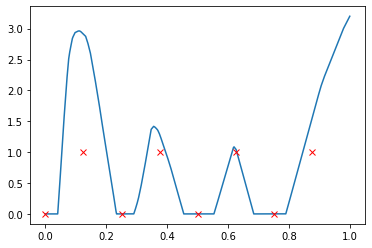

In [280]:
import matplotlib.pyplot as plt

def plot_model(nn,x,y):
  xx = np.linspace(0,1,10000)
  yy = nn.predict(xx)
  fig = plt.figure()
  plt.plot(xx,yy)
  plt.plot(x,y, 'rx')
  
plot_model(model, x_train, y_train)

# Sawtooth function

In [281]:
def relu(x):
    return (x > 0) * x

In [282]:
def relu_composed(x, n):
    f = relu(2 * relu(x) - 4 * relu(x - 0.5))
    for i in range(n-1):
        f = relu(2 * relu(f) - 4 * relu(f - 0.5))
    return f

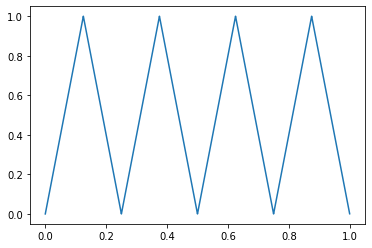

In [283]:
tt = np.arange(0, 1, 0.0001)
n = 3
plt.plot(tt,
         relu_composed(tt, n))